<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP8/Pr%C3%A1ctica_8_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 8:  Re_muestreo, reconstrucción, cuantización, compresión

##Presentado por: Ronny Guevara

## Objetivo General
Aplicar en una imagen técnicas de remuestreo y cuantiación
## Objetivos Específicos
*   Desarrollar funciones que permita realizar el remuestreo y cuantización de una imagen a diferentes escalas
*   Visualización de resultados en una interfaz amigable con el usuario

## Descripción del práctico:
Implementar un aplicativo que permita abrir una imagen y con esta obtener:

*   Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico. 
*   Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.
*   Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.
 

Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. Les sugiero recorrer la imagen mediante ciclos for anidados para una fácil implementación.

In [1]:
#Librerías a utilizar
import imageio as io
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
#Función que permite leer una imagen sin limitación de UNIT8
def get_image(dir):
  image = io.imread(dir)
  image = image.astype(np.int)
  return image

#Función que permite plotear la imagen
def plot2_image(image,Imagen, cmap=None):
  plt.figure(figsize=(100,100)) 
  plt.figure()
  plt.title(Imagen)
  plt.imshow(image,cmap=cmap)
  plt.grid(False)
  plt.show()

#Copia de la imagen Original
def image_copy(image):
  work_image=np.copy(image)
  return work_image 

#Información de la imagen
def image_info(image):
  print('This image is', image.dtype)
  print('with dimensions', image.shape)

#Normalización de las imágenes
def image_norm(image):
  norm=image.astype(np.float64)/255
  return norm

#Conversión RGB2YIQ
def image_RGB2YIQ(image):
  matrixYIQ=np.array([[0.299,0.587,0.144],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
  YIQ=np.dot(image,matrixYIQ)
  y = YIQ[:,:,0]
  i = YIQ[:,:,1]
  q = YIQ[:,:,2]
  y = np.clip(y, 0 ,1)
  q = np.clip(q,-0.5957 , 0.5957 )
  i = np.clip(i, -0.5226 , 0.5226) 
  return y, i, q

#Construcción de la imagen a partir de las componentes YIQ
def yiq_to_image(y,i,q):
  Shape = y.shape
  im_out = np.zeros((Shape[0], Shape[1], 3))
  im_out[:,:,0] = y
  im_out[:,:,1] = i
  im_out[:,:,2] = q
  return im_out.astype(np.float64)
  
#Conversión YIQ2RGB
def image_YIQ2RGB(image):
  matrixRGB=np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
  RGB=np.dot(image,matrixRGB)
  RGB=RGB.clip(0,1)*255
  RGB=RGB.astype(np.uint8)
  return RGB

#Guardar la imagen resultante 
def save_image(image):
  io.imwrite('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg',(image).astype(np.float64))

In [3]:
#Función padding
def padding (image1, dato):
  f1, c1, _ = image1.shape
  dato = dato - 1
  dato2 = (dato * 2/3)
  dato3 = math.trunc(dato2)
  fmax = f1 + dato
  cmax = c1 + dato
  im1_new = np.zeros ((fmax, cmax,3), dtype='float')
  for i in range(f1):
    for j in range(c1): 
      im1_new[i+dato3,j+dato3,:] = image1[i,j,:]
  return im1_new, fmax, cmax, dato3, f1, c1


Incluido el drive en el trabajo se procede a leer las imagenes, permitiendo al usuario seleccionar la imagen que desee.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 7200x7200 with 0 Axes>

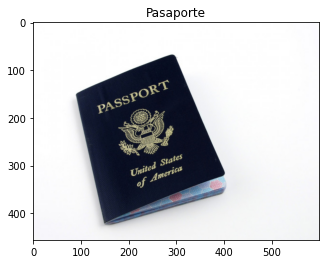

In [5]:
#@title Selecciona la imagen { run: "auto" }
Pasaporte='/content/drive/MyDrive/Colab Notebooks/PASAPORTE.jpg'
Coliseo='/content/drive/MyDrive/Colab Notebooks/Coliseo.jpg'
Isla='/content/drive/MyDrive/Colab Notebooks/Isla.jpg'
Imagen = 'Pasaporte' #@param ["Pasaporte", "Coliseo", "Isla"]

if Imagen == 'Pasaporte':
  image = get_image(Pasaporte)
  plot2_image(image, 'Pasaporte')
elif Imagen == 'Isla':
  image = get_image(Isla)
  plot2_image(image, 'Isla')
elif Imagen == 'Coliseo':
  image = get_image(Coliseo)
  plot2_image(image, 'Coliseo')

In [6]:
#Proceso de copia de la imagen y visualización de información
work_image=image_copy(image)
image_info(work_image)

This image is int64
with dimensions (456, 600, 3)


<Figure size 7200x7200 with 0 Axes>

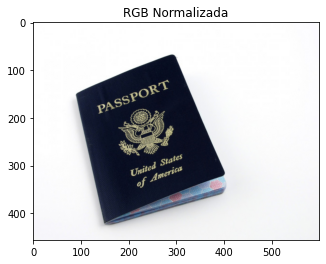

In [7]:
#Normalización de la imagen y conversión del espacio RGB a YIQ
work_image=image_norm(work_image)
plot2_image(work_image,'RGB Normalizada',cmap=None)

<Figure size 7200x7200 with 0 Axes>

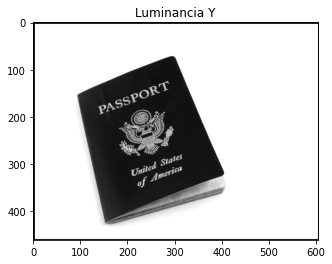

In [8]:
ima, fmax, cmax, dato, f1, c1 = padding (work_image, 7)
y, i, q = image_RGB2YIQ(ima)
plot2_image(y,'Luminancia Y',cmap='gray')

## Visualización individual
### Upsampling

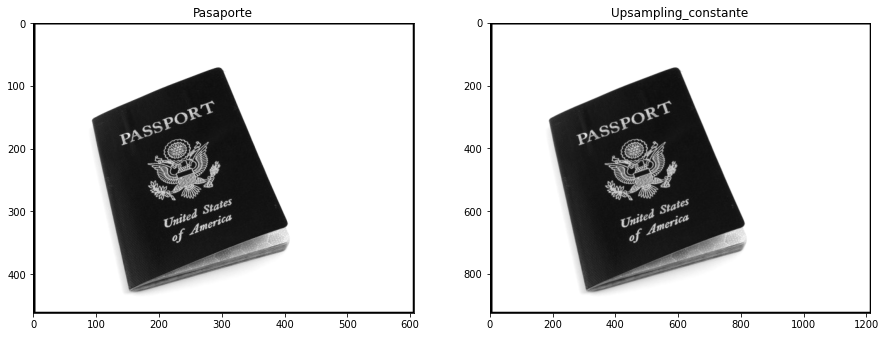

In [9]:
#upsampling_constante
im = y.copy() / y.max()
im_h = im.shape[0] 
im_w = im.shape[1] 
fmax = im_h*2
cmax = im_w*2
out2 = np.zeros((fmax, cmax), dtype='float')
for i in range(im_h):
  for j in range(im_w):
    out2 [2*i:2*i+2,2*j:2*j+2] = im [i,j]
    Upsampling_constante = out2
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(Upsampling_constante,'gray')
axes[1].set_title('Upsampling_constante')
plt.show()

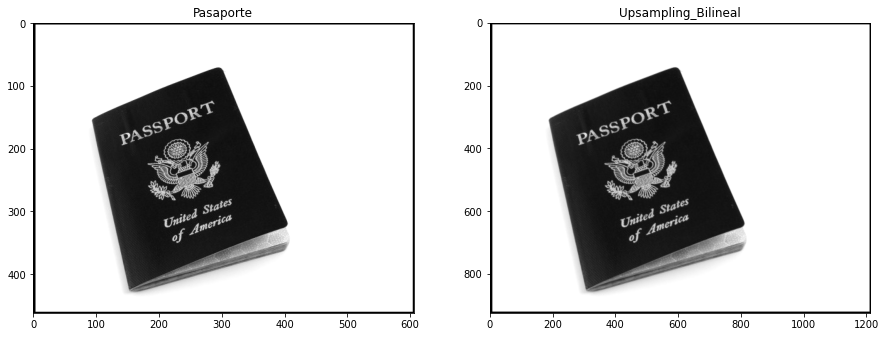

In [23]:
#upsampling_Bilineal
im = y.copy() / y.max()
im_h = im.shape[0] 
im_w = im.shape[1] 
fmax = im_h*2
cmax = im_w*2
out2 = np.zeros((fmax, cmax), dtype='float')
for i in range(im_h-1):
  for j in range(im_w-1):
    out2 [2*i, 2*j] = im [i,j]
    out2 [2*i, 2*j+1] = np.mean([im[i,j], im[i,j+1]])
    out2 [2*i+1, 2*j] = np.mean([im[i,j], im[i+1,j]])
    out2 [2*i+1, 2*j+1] = np.mean([im[i,j], im[i+1,j+1]])
    Upsampling_Bilineal = out2
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out2,'gray')
axes[1].set_title('Upsampling_Bilineal')
plt.show()

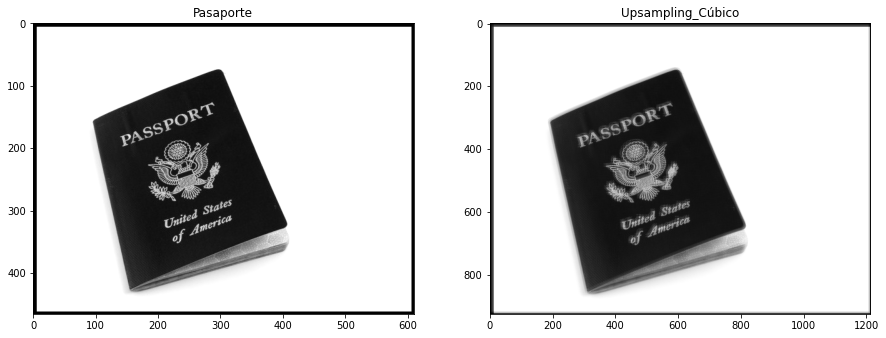

In [24]:
#upsampling_cúbico
kernel=np.array([-1/8, 5/8, 5/8, -1/8])
kernel2=np.array([[0.015625 , -0.078125, -0.078125, 0.015625],
                 [-0.078125 , 0.390625, 0.390625, -0.078125], 
                 [-0.078125 , 0.390625, 0.390625, -0.078125], 
                 [0.015625 , -0.078125, -0.078125, 0.015625]])
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
fmax = im_h*2
cmax = im_w*2
out = np.zeros(im.shape) 
out2 = np.zeros((fmax, cmax), dtype='float')
im = np.pad(im, 2, mode='minimum')
for i in range(im_h-1):
  for j in range(im_w-1):
    out2 [2*i, 2*j] = im [i,j]
    out2 [2*i, 2*j+1] = np.mean([im[i,j], im[i,j+4]])
    out2 [2*i+1, 2*j] = np.mean([im[i,j], im[i+4,j]])
    out2 [2*i+1, 2*j+1] = np.mean([im[i,j], im[i+4,j+4]])
    Upsampling_Cúbico = out2
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out2,'gray')
axes[1].set_title('Upsampling_Cúbico')
plt.show()

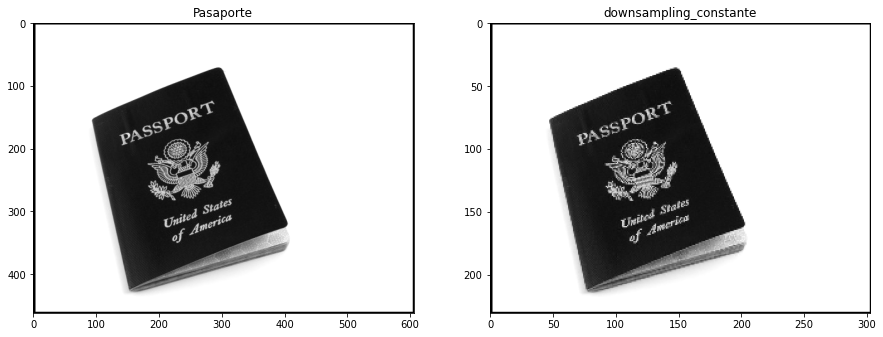

In [25]:
#downsampling_constante 
im = y.copy() / y.max()
im_h = im.shape[0] 
im_w = im.shape[1] 
fmax = im_h//2
cmax = im_w//2
out2 = np.zeros((fmax, cmax), dtype='float')
for i in range(fmax):
  for j in range(cmax):
    out2 [i,j] = im [2*i, 2*j]
    downsampling_constante = out2
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out2,'gray')
axes[1].set_title('downsampling_constante')
plt.show()

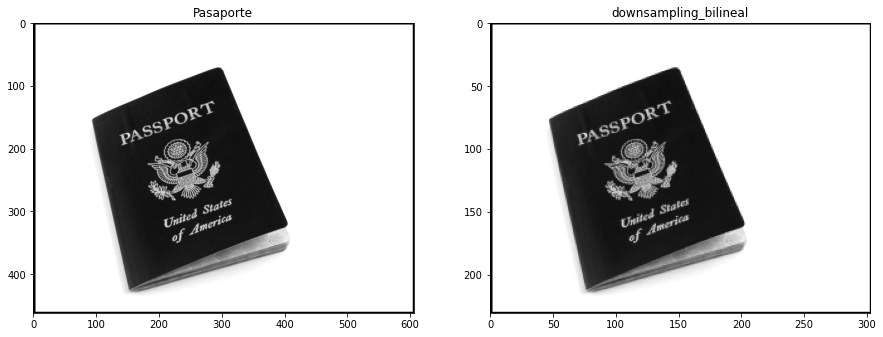

In [26]:
#downsampling_bilineal
im = y.copy() / y.max()
im_h = im.shape[0] 
im_w = im.shape[1] 
fmax = im_h//2
cmax = im_w//2
out2 = np.zeros((fmax, cmax), dtype='float')
for i in range(fmax):
  for j in range(cmax):
    out2 [i,j] = np.mean(im [2*i:2*i+2,2*j:2*j+2])
    downsampling_bilineal = out2
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(downsampling_bilineal,'gray')
axes[1].set_title('downsampling_bilineal')
plt.show()

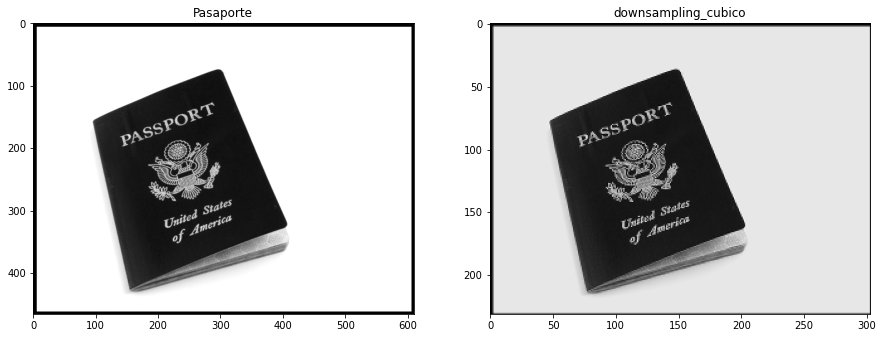

In [27]:
#downsampling_cubico
kernel=np.array([[0.015625 , -0.078125, -0.078125, 0.015625],
                 [-0.078125 , 0.390625, 0.390625, -0.078125], 
                 [-0.078125 , 0.390625, 0.390625, -0.078125], 
                 [0.015625 , -0.078125, -0.078125, 0.015625]])
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
fmax = im_h//2
cmax = im_w//2
out = np.zeros(im.shape) 
out2 = np.zeros((fmax, cmax), dtype='float')
im = np.pad(im, 2, mode='minimum')
for i in range(fmax):
    for j in range(cmax):
      out2[i, j] = np.multiply(kernel, im[2*i:2*i+4,2*j:2*j+4]).sum()
      downsampling_cubico = out2
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out2,'gray')
axes[1].set_title('downsampling_cubico')
plt.show() 

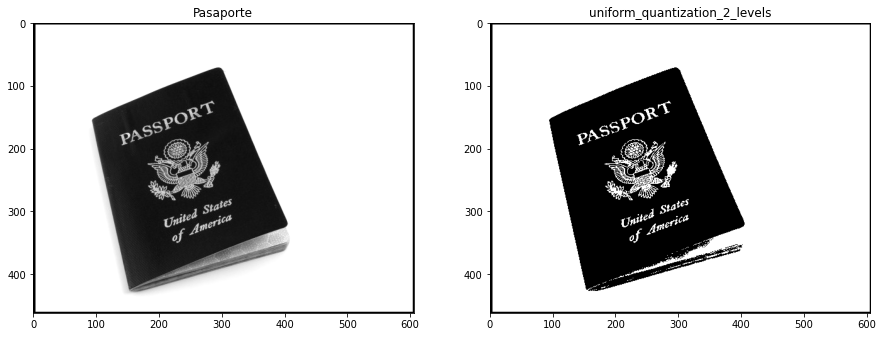

In [28]:
#Cuantización_uniforme_2_niveles
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
out = np.zeros(im.shape) 
for i in range(im_h):
    for j in range(im_w):
      if im[i,j]>=0.5:
        out[i,j]=1;
      elif im[i,j]<=0.5:
        out[i,j]=0;
        uniform_quantization_2_levels = out
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('uniform_quantization_2_levels')
plt.show() 

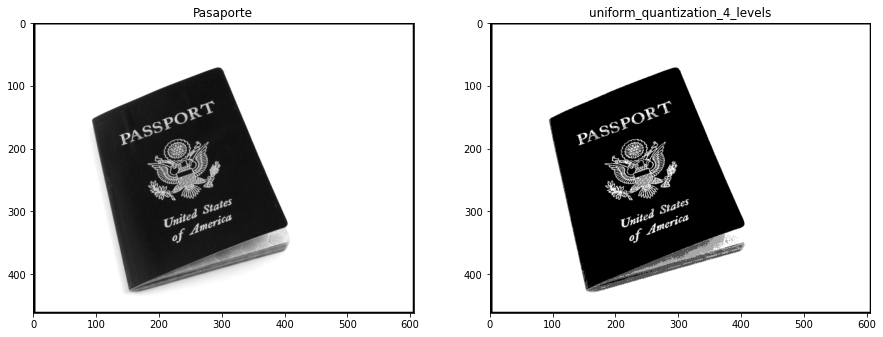

In [29]:
#Cuantización_uniforme_4_niveles
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
out = np.zeros(im.shape) 
for i in range(im_h):
    for j in range(im_w):
      if im[i,j]>=0 and im[i,j]<=0.25:
        out[i,j]=0;
      elif im[i,j]>=0.25 and im[i,j]<=0.50:
        out[i,j]=0.33;
      elif im[i,j]>=0.50 and im[i,j]<=0.75:
        out[i,j]=0.66;
      elif im[i,j]>=0.75 and im[i,j]<=1:
        out[i,j]=1;
        uniform_quantization_4_levels = out
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('uniform_quantization_4_levels')
plt.show()  

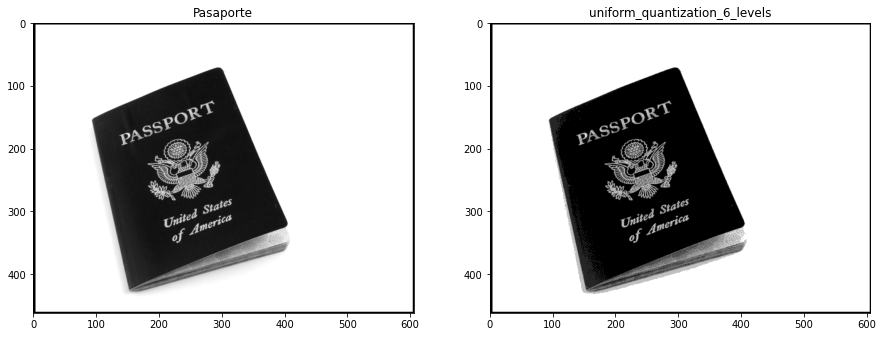

In [30]:
#Cuantización_uniforme_6_niveles
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
out = np.zeros(im.shape) 
for i in range(im_h):
    for j in range(im_w):
      if im[i,j]>=0 and im[i,j]<=0.15:
        out[i,j]=0;
      elif im[i,j]>=0.15 and im[i,j]<=0.30:
        out[i,j]=0.15;
      elif im[i,j]>=0.30 and im[i,j]<=0.45:
        out[i,j]=0.30;
      elif im[i,j]>=0.45 and im[i,j]<=0.60:
        out[i,j]=0.45;
      elif im[i,j]>=0.60 and im[i,j]<=0.75:
        out[i,j]=0.60;
      elif im[i,j]>=0.75 and im[i,j]<=0.90:
        out[i,j]=0.75;
      elif im[i,j]>=0.90 and im[i,j]<=1:
        out[i,j]=1;
        uniform_quantization_6_levels = out
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('uniform_quantization_6_levels')
plt.show()  

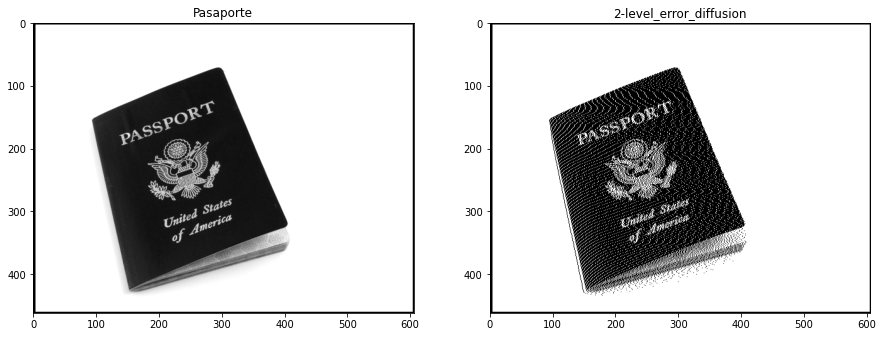

In [33]:
#Difusión_por_error_2_niveles
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
out = np.zeros(im.shape) 
for i in range(im_h):
  error=0
  for j in range(im_w):
    out[i,j] = round(im[i,j] * (2-1) + error)/(2-1)
    error = error - out[i,j] + im[i,j]
    two_level_error_diffusion = out
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('2-level_error_diffusion')
plt.show()  

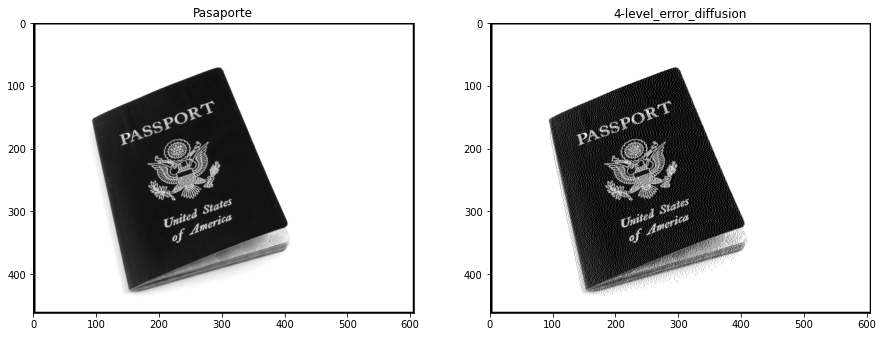

In [39]:
#Difusión_por_error_4 niveles
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
out = np.zeros(im.shape) 
for i in range(im_h):
  error=0
  for j in range(im_w):
    out[i,j] = round(im[i,j] * (4-1) + error)/(4-1)
    error = error - out[i,j] + im[i,j]
    four_level_error_diffusion = out
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('4-level_error_diffusion')
plt.show()  

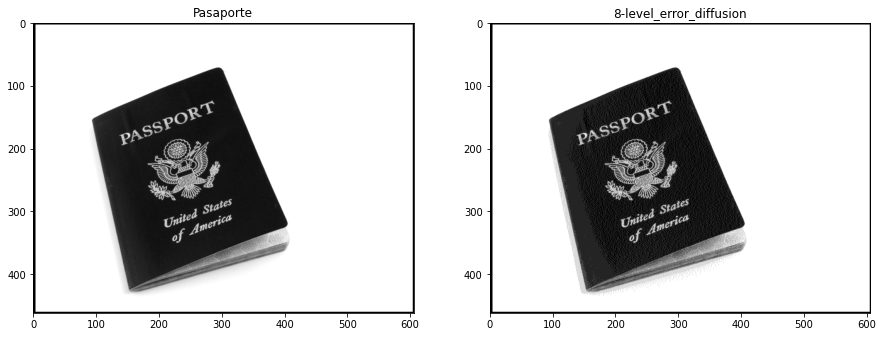

In [37]:
#Difusión_por_error_8 niveles
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
out = np.zeros(im.shape) 
for i in range(im_h):
  error=0
  for j in range(im_w):
    out[i,j] = round(im[i,j] * (8-1) + error)/(8-1)
    error = error - out[i,j] + im[i,j]
    eight_level_error_diffusion = out
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('8-level_error_diffusion')
plt.show()  

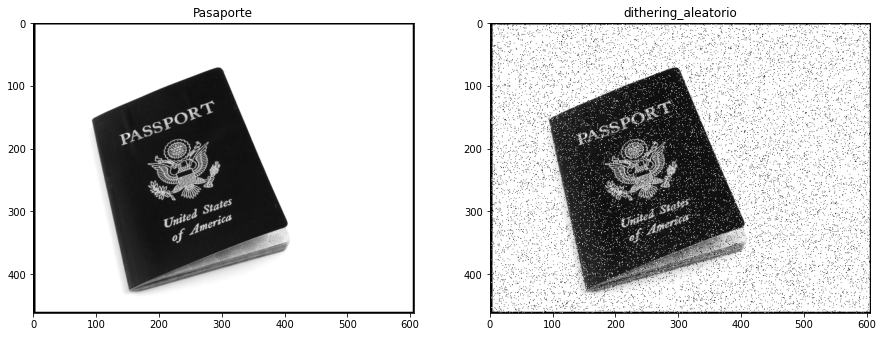

In [36]:
#dithering_aleatorio
im = y.copy()
im_h = im.shape[0] 
im_w = im.shape[1]
prob = 1 - 0.05
out = np.zeros(im.shape) 
for i in range(im_h):
  for j in range(im_w):
    arn = random.random()
    if arn < 0.05:
      out[i,j] = 0
    elif arn > prob:
      out[i,j] = 1
    else:
      out[i,j] = im [i,j]
      dithering_aleatorio = out
    
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(im,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(out,'gray')
axes[1].set_title('dithering_aleatorio')
plt.show()  

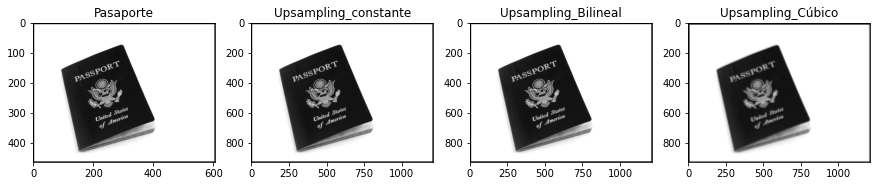

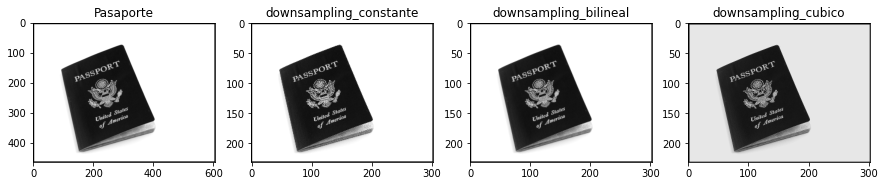

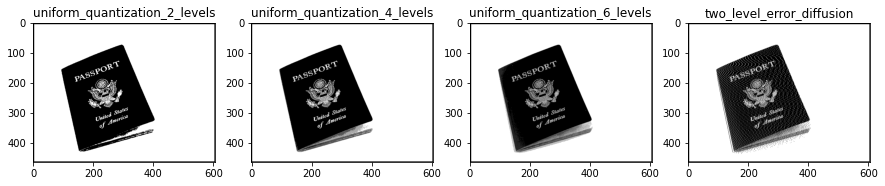

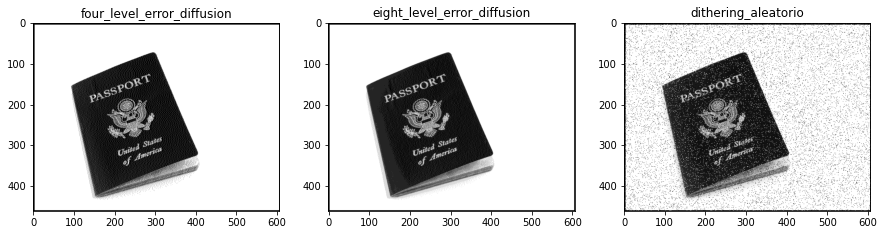

In [47]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(Upsampling_constante,'gray')
axes[1].set_title('Upsampling_constante')
axes[2].imshow(Upsampling_Bilineal,'gray')
axes[2].set_title('Upsampling_Bilineal')
axes[3].imshow(Upsampling_Cúbico,'gray')
axes[3].set_title('Upsampling_Cúbico')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(downsampling_constante,'gray')
axes[1].set_title('downsampling_constante')
axes[2].imshow(downsampling_bilineal,'gray')
axes[2].set_title('downsampling_bilineal')
axes[3].imshow(downsampling_cubico,'gray')
axes[3].set_title('downsampling_cubico')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(uniform_quantization_2_levels,'gray')
axes[0].set_title('uniform_quantization_2_levels')
axes[1].imshow(uniform_quantization_4_levels,'gray')
axes[1].set_title('uniform_quantization_4_levels')
axes[2].imshow(uniform_quantization_6_levels,'gray')
axes[2].set_title('uniform_quantization_6_levels')
axes[3].imshow(two_level_error_diffusion,'gray')
axes[3].set_title('two_level_error_diffusion')
plt.show()

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15,15)
axes[0].imshow(four_level_error_diffusion,'gray')
axes[0].set_title('four_level_error_diffusion')
axes[1].imshow(eight_level_error_diffusion,'gray')
axes[1].set_title('eight_level_error_diffusion')
axes[2].imshow(dithering_aleatorio,'gray')
axes[2].set_title('dithering_aleatorio')
plt.show()

###Resultados
Implementar un aplicativo que permita abrir una imagen y con esta obtener:

*   Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico. 
*   Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.
*   Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

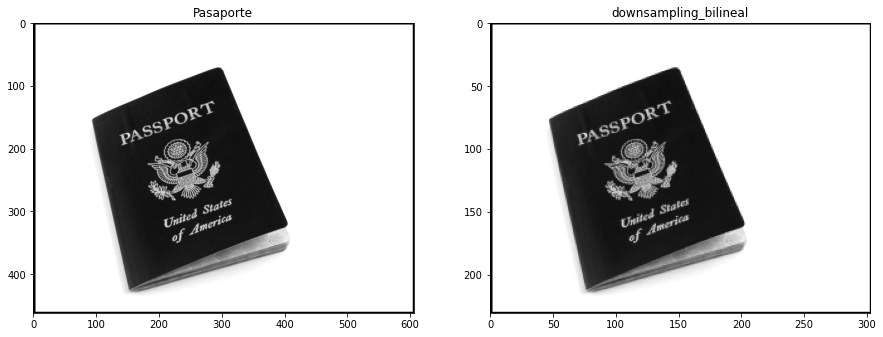

In [38]:
#@title Selecciona la imagen { run: "auto" }
Option = 'Downsampling' #@param ["Upsampling","Downsampling"]
Option_2 = 'bilineal' #@param ["constante","bilineal","bicúbico"]

if Option == 'Upsampling' and Option_2 == "constante":
  im = y.copy() / y.max()
  im_h = im.shape[0] 
  im_w = im.shape[1] 
  fmax = im_h*2
  cmax = im_w*2
  out2 = np.zeros((fmax, cmax), dtype='float')
  for i in range(im_h):
    for j in range(im_w):
      out2 [2*i:2*i+2,2*j:2*j+2] = im [i,j]

  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(out2,'gray')
  axes[1].set_title('Upsampling_constante')
  plt.show()
elif Option == 'Upsampling' and Option_2 == "bilineal":
  im = y.copy() / y.max()
  im_h = im.shape[0] 
  im_w = im.shape[1] 
  fmax = im_h*2
  cmax = im_w*2
  out2 = np.zeros((fmax, cmax), dtype='float')
  for i in range(im_h-1):
    for j in range(im_w-1):
      out2 [2*i, 2*j] = im [i,j]
      out2 [2*i, 2*j+1] = np.mean([im[i,j], im[i,j+1]])
      out2 [2*i+1, 2*j] = np.mean([im[i,j], im[i+1,j]])
      out2 [2*i+1, 2*j+1] = np.mean([im[i,j], im[i+1,j+1]])
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(out2,'gray')
  axes[1].set_title('Upsampling_Bilineal')
  plt.show()

elif Option == 'Upsampling' and Option_2 == "bicúbico":
  kernel=np.array([-1/8, 5/8, 5/8, -1/8])
  kernel2=np.array([[0.015625 , -0.078125, -0.078125, 0.015625],
                  [-0.078125 , 0.390625, 0.390625, -0.078125], 
                  [-0.078125 , 0.390625, 0.390625, -0.078125], 
                  [0.015625 , -0.078125, -0.078125, 0.015625]])
  im = y.copy()
  im_h = im.shape[0] 
  im_w = im.shape[1]
  fmax = im_h*2
  cmax = im_w*2
  out = np.zeros(im.shape) 
  out2 = np.zeros((fmax, cmax), dtype='float')
  im = np.pad(im, 2, mode='minimum')
  for i in range(im_h-1):
    for j in range(im_w-1):
      out2 [2*i, 2*j] = im [i,j]
      out2 [2*i, 2*j+1] = np.mean([im[i,j], im[i,j+4]])
      out2 [2*i+1, 2*j] = np.mean([im[i,j], im[i+4,j]])
      out2 [2*i+1, 2*j+1] = np.mean([im[i,j], im[i+4,j+4]])
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(out2,'gray')
  axes[1].set_title('Upsampling_Cúbico')
  plt.show()  

elif Option == 'Downsampling' and Option_2 == "constante":
  im = y.copy() / y.max()
  im_h = im.shape[0] 
  im_w = im.shape[1] 
  fmax = im_h//2
  cmax = im_w//2
  out2 = np.zeros((fmax, cmax), dtype='float')
  for i in range(fmax):
    for j in range(cmax):
      out2 [i,j] = im [2*i, 2*j]
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(out2,'gray')
  axes[1].set_title('downsampling_constante')
  plt.show() 

elif Option == 'Downsampling' and Option_2 == "bilineal":
  im = y.copy() / y.max()
  im_h = im.shape[0] 
  im_w = im.shape[1] 
  fmax = im_h//2
  cmax = im_w//2
  out2 = np.zeros((fmax, cmax), dtype='float')
  for i in range(fmax):
    for j in range(cmax):
      out2 [i,j] = np.mean(im [2*i:2*i+2,2*j:2*j+2])
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(out2,'gray')
  axes[1].set_title('downsampling_bilineal')
  plt.show()
elif Option == 'Downsampling' and Option_2 == "bicúbico":
  kernel=np.array([[0.015625 , -0.078125, -0.078125, 0.015625],
                  [-0.078125 , 0.390625, 0.390625, -0.078125], 
                  [-0.078125 , 0.390625, 0.390625, -0.078125], 
                  [0.015625 , -0.078125, -0.078125, 0.015625]])
  im = y.copy()
  im_h = im.shape[0] 
  im_w = im.shape[1]
  fmax = im_h//2
  cmax = im_w//2
  out = np.zeros(im.shape) 
  out2 = np.zeros((fmax, cmax), dtype='float')
  im = np.pad(im, 2, mode='minimum')
  for i in range(fmax):
      for j in range(cmax):
        out2[i, j] = np.multiply(kernel, im[2*i:2*i+4,2*j:2*j+4]).sum()
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(out2,'gray')
  axes[1].set_title('downsampling_bicúbico')
  plt.show() 

#### Análisis de los resultados:


*   El trabajo práctico desarrollado permite al usuario seleccionar una imagen,posterior trasladarla al espacio YIQ, y trabajar con la luminancia, aplicando remuestreo y cuantización
*   El aplicativo permite al usuario seleccionar cualquiera de las opciones del Downsampling y Upsampling, los resultados indican que apesar de reducir o aumentar la escala de la imagen, los detalles se siguen conservando y estos dependen si se aplica un kernel constante, bilineal o bicúbico.
*   Con respecto a la cuantización uniforme, podemos apreciar que los resultados son más aceptables cuando se utiliza niveles de cuantización de 8 o mayores.


